#Read frames in videos

In [ ]:
import os
import cv2

In [ ]:
def get_images(file_path):
  cap = cv2.VideoCapture(file_path)
  if not cap.isOpened():
      print(f"Cannot open file: {file_path}")
      exit()
  i = 0
  fps = round(cap.get(cv2.CAP_PROP_FPS))
  while True:
      # Capture frame-by-frame
      ret, frame = cap.read()

      # if frame is read correctly ret is True
      if not ret:
          print("Can't receive frame (stream end?). Exiting ...")
          break
      if (i%fps*2 == 0):
        cv2.imwrite(f'images/{file_path[:-4]}_{i//fps:06}.png', frame)
      i += 1

  # When everything done, release the capture
  cap.release()

In [ ]:
for f in os.listdir('.'):
  # print(f)
  get_images(f)

Can't receive frame (stream end?). Exiting ...
Cannot open file: images
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). 

# Create model and compute embeds

In [ ]:
import torch
import clip
from PIL import Image
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
import tqdm

In [ ]:
images_embeds = []
for f in tqdm.tqdm(os.listdir('./images')):
  image = preprocess(Image.open(f'./images/{f}')).unsqueeze(0).to(device)
  with torch.no_grad():
    images_embeds.append(model.encode_image(image).cpu().squeeze().numpy())

100%|████████████████████████████████████████████████████████████████████████████| 29880/29880 [10:01<00:00, 49.71it/s]


In [ ]:
def show_samples_from_cluster(clusters, n=0, save=None):
  plt.figure(figsize=(7,7))
  images_paths = os.listdir('./images')
  args = np.nonzero(clusters==n)[0]
  if len(args) > 15:
    args = np.random.choice(args, 15, replace=False)
  plt.tight_layout()
  for idx, arg in enumerate(args):
    plt.subplot(3,5,idx+1)
    plt.axis('off')
    plt.imshow(Image.open(f'./images/{images_paths[arg]}'))
  if save:
    plt.savefig(f'{save}/{n}.png')
  else:
    plt.show()
  plt.close()

# Cluster analysis

## t-SNE

In [ ]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tsne_embeds = sklearn.manifold.TSNE(n_components=2, perplexity=50).fit_transform(np.array(images_embeds))

### KMeans

In [ ]:
tsne_kmeans = sklearn.cluster.KMeans(init="k-means++", n_clusters=100)
tsne_clusters = tsne_kmeans.fit_predict(tsne_embeds)

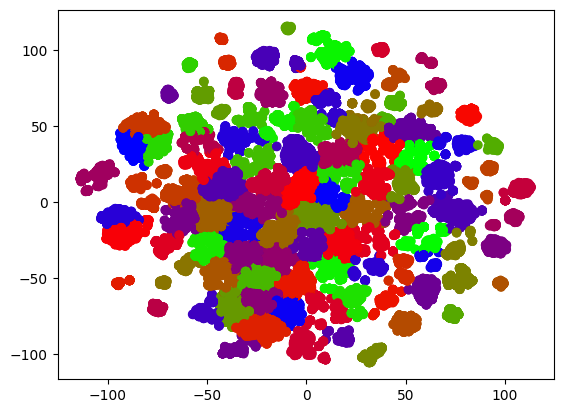

In [ ]:
plt.scatter(tsne_embeds[:,0],tsne_embeds[:,1], c=tsne_clusters, cmap='brg')
plt.show()

In [ ]:
for i in range(100):
  show_samples_from_cluster(tsne_clusters, i, save='tsne_kmeans')

### HDBSCAN

In [ ]:
tsne_HDBSCAN = sklearn.cluster.HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=3)
tsne_hclusters = tsne_HDBSCAN.fit_predict(tsne_embeds)

In [ ]:
np.unique(tsne_hclusters)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168])

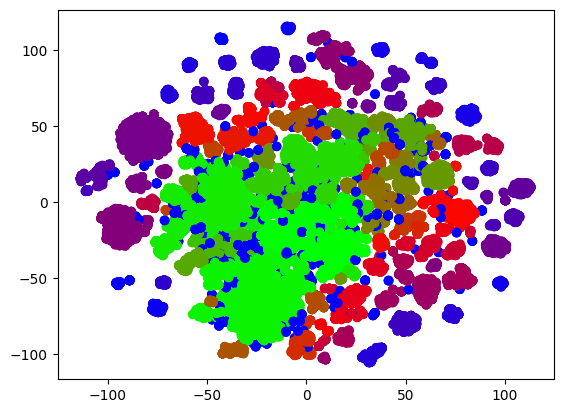

In [ ]:
plt.scatter(tsne_embeds[:,0],tsne_embeds[:,1], c=tsne_hclusters, cmap='brg')
plt.show()

In [ ]:
for i in np.unique(tsne_hclusters):
  show_samples_from_cluster(tsne_clusters, i, save='tsne_hdbscan')

## PCA

In [ ]:
reduced_data = sklearn.decomposition.PCA(n_components=2).fit_transform(np.array(images_embeds))

In [ ]:
pca_kmeans = sklearn.cluster.KMeans(init="k-means++", n_clusters=10, n_init=4)
pca_clusters = pca_kmeans.fit_predict(reduced_data)

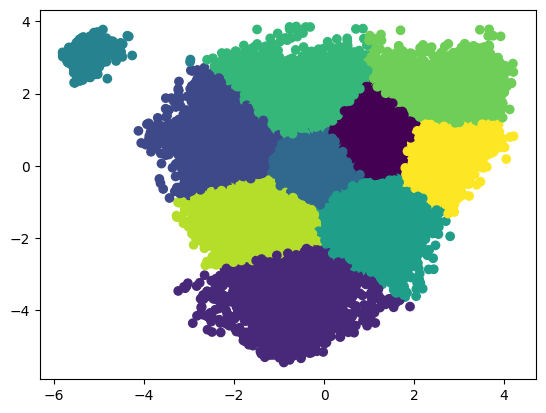

In [ ]:
plt.scatter(reduced_data[:,0],reduced_data[:,1], c=pca_clusters)
plt.show()

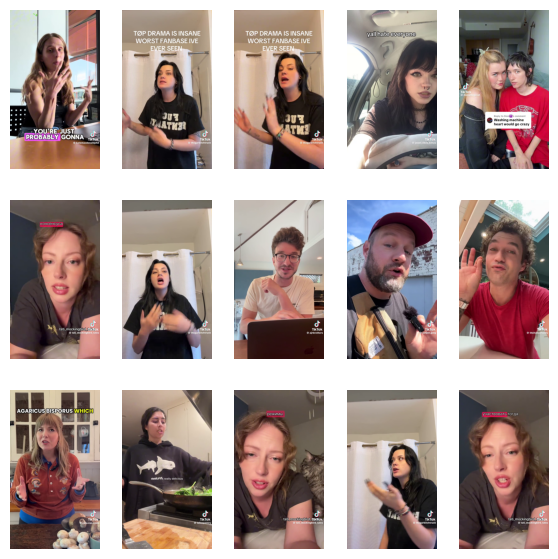

In [ ]:
show_samples_from_cluster(pca_clusters, 9)

#LSH

## Setup

In [ ]:
def brute_force_query(X, x, n, X_split=[]):
  if len(X_split)>0:
    X = X[X_split]
    dists = np.linalg.norm(X - x, axis=1)
    idx = np.argsort(dists)[:n]
    return X_split[idx], dists[idx]
  else:
    dists = np.linalg.norm(X - x, axis=1)
    idx = np.argsort(dists)[:n]
    return idx, dists[idx]

In [ ]:
class LSH():
  def __init__(self, k, n_dim):
    self.k = k
    self.n_dim = n_dim
    self.p = p
    self.vectors = np.random.standard_normal((k,n_dim))
    self.bias = np.random.rand(k) * 2 - 1
    self.database = np.array([])
  def fit(self, X):
    hashes = np.dot(X, self.vectors.T) > self.bias
    self.database = hashes
  def get_similar(self, x):
    hash = np.dot(x, self.vectors.T) > self.bias
    hits = np.logical_not(np.logical_xor(self.database,hash))

    hit_idx = np.argwhere(np.all(hits,axis=1)).T[0]

    return hit_idx

In [ ]:
embeds = np.array(images_embeds) / np.linalg.norm(np.array(images_embeds), axis=1, keepdims=True)

In [ ]:
k = 20
n_dim = 512
L = 20

In [ ]:
lsh = [LSH(k, n_dim) for i in range(L)]

In [ ]:
[lsh[i].fit(embeds) for i in range(L)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Поиск по кадру видео

In [ ]:
def plot_sim(args):
  plt.figure(figsize=(7,7))
  images_paths = os.listdir('./images')
  plt.tight_layout()
  for i in range(min(16, len(args[0]))):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.title(1-args[1][i])
    plt.imshow(Image.open(f'./images/{images_paths[args[0][i]]}'))
  plt.show()
  plt.close()

In [ ]:
def calc_sim(j):
  sim = [lsh[i].get_similar(embeds[j]) for i in range(L)]
  return brute_force_query(embeds, embeds[j], 16)#, np.unique(np.concatenate(sim)))

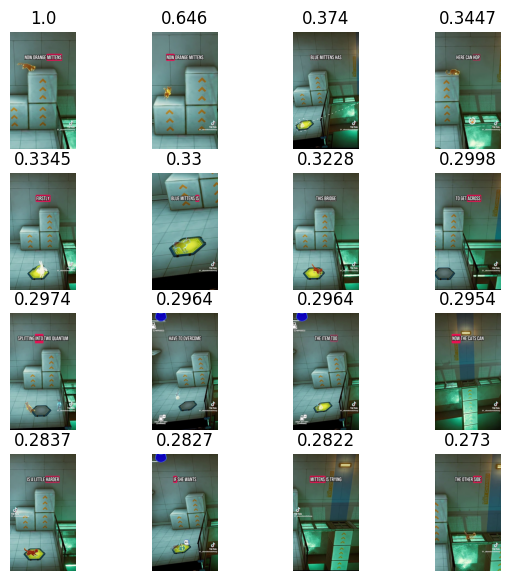

In [ ]:
plot_sim(calc_sim(100))

## Поиск по изображению

In [ ]:
def find_sim(im_e):
  sim = [lsh[i].get_similar(im_e) for i in range(L)]
  return brute_force_query(embeds, im_e, 16)#, np.unique(np.concatenate(sim)))

In [ ]:
def plot_found_sim(im, args):
  plt.figure(figsize=(7,7))
  images_paths = os.listdir('./images')
  plt.tight_layout()
  plt.subplot(4,4,1)
  plt.axis('off')
  plt.title(1)
  plt.imshow(im)
  for i in range(min(15, len(args[0]))):
    plt.subplot(4,4,i+2)
    plt.axis('off')
    plt.title(1-args[1][i])
    plt.imshow(Image.open(f'./images/{images_paths[args[0][i]]}'))
  plt.show()
  plt.close()

In [ ]:
def master_find(img_path):
  img2find = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
  with torch.no_grad():
    img2find_embed= model.encode_image(img2find).cpu().squeeze().numpy()
  img2find_embed /= np.linalg.norm(img2find_embed)
  plot_found_sim(Image.open(img_path),find_sim(img2find_embed))

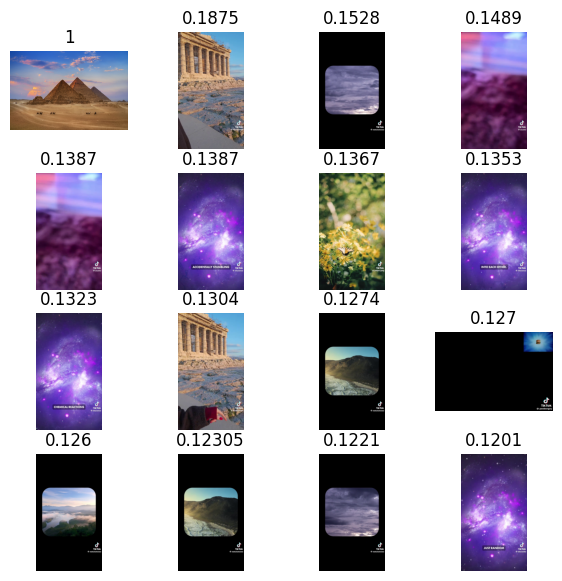

In [ ]:
master_find('../giza-egypt-pyramids-in-sunset-scene--wonders-of-the-world--1085205362-e1d04d7e00e94c4896ca58bed32e5a61-455421100.jpg')

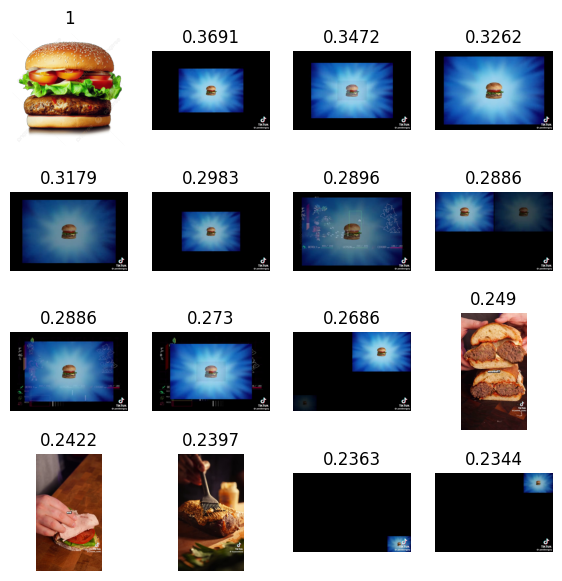

In [ ]:
master_find('../pngtree-fast-food-big-ham-burger-png-image_8648590-2201603022.png')

## Поиск по тексту

In [ ]:
def master_find_text(message):
  txt2find = clip.tokenize([message]).to(device)
  with torch.no_grad():
    txt2find_embed= model.encode_text(txt2find).cpu().squeeze().numpy()
  txt2find_embed /= np.linalg.norm(txt2find_embed)
  plot_sim(find_sim(txt2find_embed))

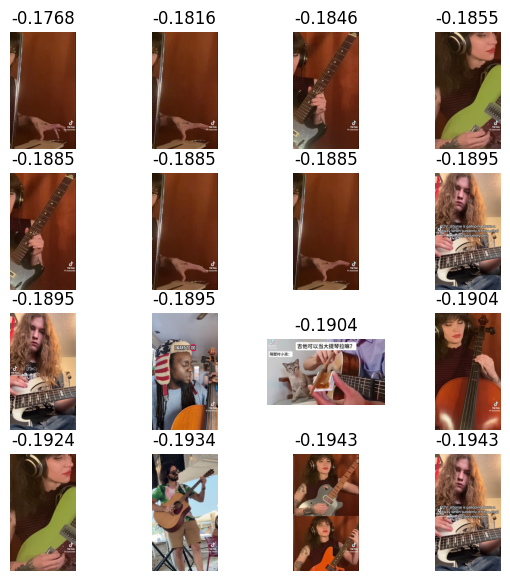

In [ ]:
master_find_text('guitar')